### Over / Under fitting of Data

Source: https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

In the previous exmample we see that the loss will eventually stagnate. This is, the model is no longer deacreasing the error and will continue to try to despite failing. This is called "over" fitting. That is, the model is trying too hard to fit to the data. This is a problem because it might start picking up things that dont matter - for example, a black pixel at index 204 means that the image is a show. Well, no. That's just a coincidence in the training data

### Solutions

The best solution is to use perfect input data that represents all possible inputs. However, this is pretty well impossible as, for example, there are nearly infinite variety of shirts coming out so getting an image of all possible shirts would be impossible. 

Instead we go for regularizing the input data. This constrains the input data so that the model learns on the important aspects and is less likely to pick up on irrelevent features.

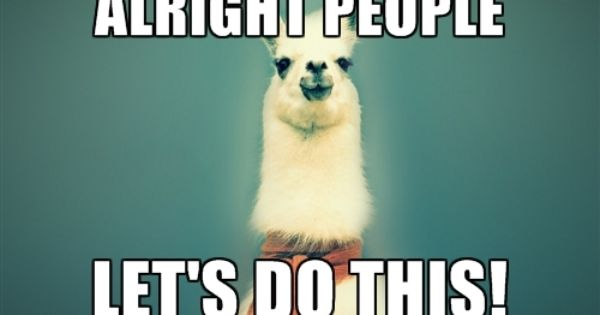

In [1]:
# This should make the GPU stop working, but it appears to make it work. IDK man
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import tensorflow as tf
# Fixing and error caused by multiple processes on the GPU
# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.4.1


In [2]:
# ??
# !pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [3]:
from  IPython import display
from matplotlib import pyplot as plt
plt.style.use('dark_background')

import numpy as np

import pathlib
import shutil
import tempfile

In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True) # oo... ignore_errors=True, that's nice

In [5]:
# Let's do some particle physics! 
# Wait, no, just using it for the tutorial. Don't worry about the details
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [6]:
FEATURES = 28

In [7]:
# Read directly from a gzip file without decompressing first - fancy
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

In [8]:
def pack_row(*row):
    """
    Converts to a (feature, label) pair
    """
    label = row[0]
    features = tf.stack(row[1:],1)
    return features, label

In [9]:
# Doing this 10,000 rows at a time
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


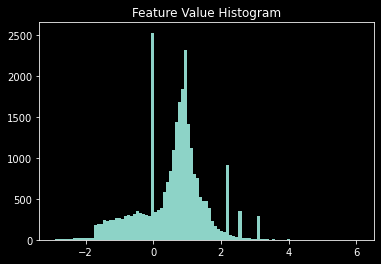

In [10]:
# Checkout the data
for features,label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins = 101)
    plt.title('Feature Value Histogram')

In [11]:
# 1000 for validation, 10,000 for traininga
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [12]:
# Caching some data so we don't read the file every time
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [13]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [14]:
# Get a batch of data to test with
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## Demonstrating Overfitting

We can prevent overfitting by restricting the number of variables that we are exposing to the model. The main take away here -models are good at fitting to the input data, but we are trying to generalize, not just fit the input data. Knowing what the outcome is for data that we already have is useless. We want to generalize the rules for any data that may come up

### Finding the right number of inputs and layers

There is no magic formula for this right now. Which means you need to basically "play" with it. Start off with a few parameters and build up from there. Add more parameters and layers until dimishing returns start appearing. So, let's do that

In [15]:
# We are going to reduce the learning rate over time
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

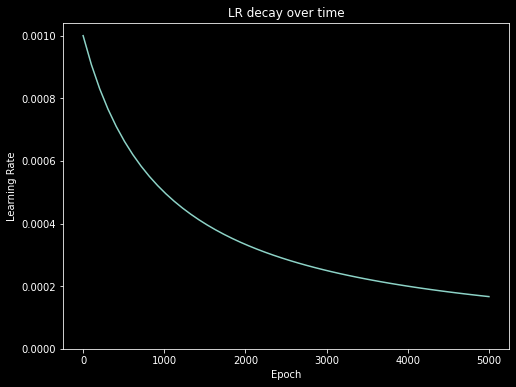

In [16]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
plt.title("LR decay over time")
_ = plt.ylabel('Learning Rate')

In [17]:
# Need to set everything up so we can reuse it as needed
def get_callbacks(name):
    """
    Generate tensorboard logs
    """
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name),
    ]

In [18]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    """
    Compile and fit all in one step.
    Args: 
        model - tensorflow model to user
        name - name of model
        optimizer - which optimizer to use
        max_epochs - how many epochs to use
    """
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

    model.summary()

    history = model.fit(
        train_ds,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=validate_ds,
        callbacks=get_callbacks(name),
        verbose=0)
    return history

In [19]:
# Let's make a little baby model with one layer
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [20]:
size_histories = {} # to store results

In [21]:
%%time
# Compile and train
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4838,  binary_crossentropy:0.7676,  loss:0.7676,  val_accuracy:0.4950,  val_binary_crossentropy:0.7247,  val_loss:0.7247,  
....................................................................................................
Epoch: 100, accuracy:0.6012,  binary_crossentropy:0.6231,  loss:0.6231,  val_accuracy:0.5870,  val_binary_crossentropy:0.6195,  val_loss:0.6195,  
....................................................................................................
Epoch: 200, accuracy:0.63

(0.5, 0.7)

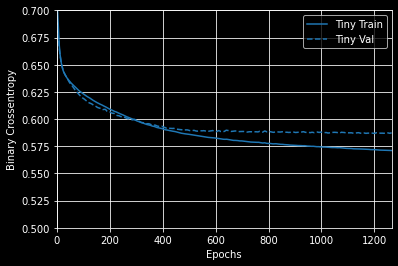

In [22]:
# How was model?
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

In [23]:
# Making a large model - two layers now
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [24]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4754,  binary_crossentropy:0.7340,  loss:0.7340,  val_accuracy:0.4530,  val_binary_crossentropy:0.7107,  val_loss:0.7107,  
....................................................................................................
Epoch: 100, accuracy:0.6297,  binary_crossentropy:0.6090,  loss:0.6090,  val_accuracy:0.6290,  val_binary_crossentropy:0.6065,  val_loss:0.

In [25]:
# Medium model - 3 layers with 64 each
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4928,  binary_crossentropy:0.6931,  loss:0.6931,  val_accuracy:0.4970,  val_binary_crossentropy:0.6827,  val_loss:0.6827,  
....................................................................................................
E

In [26]:
# Large model 
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])
size_histories['large'] = compile_and_fit(large_model, "sizes/large")


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5131,  binary_crossentropy:0.7682,  loss:0.7682,  val_accuracy:0.4850,  val_binary_crossentr

Text(0.5, 0, 'Epochs [Log Scale]')

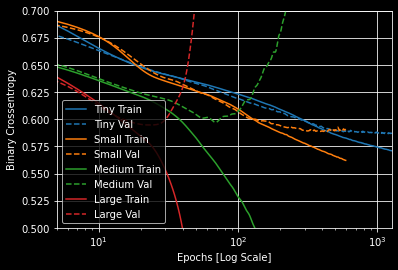

In [27]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [28]:
# Instead of doing this all manually, we can just checkout the logs that they made
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 8880.

In [29]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

### How to prevent overfitting

We are going to make a copy o the tiny model first to compare for later

In [30]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True) # Remove previous saved runs if any
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

WindowsPath('C:/Users/antho/AppData/Local/Temp/tmp1kowjbsn/tensorboard_logs/regularizers/Tiny')

In [31]:
# Save for later
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

In nueral networks we can often use more complicated models to explain to same data as less complicated models. Less complcated models are also less likely to overfit the model as they are considering less relations. Therefore, the simpler the model (generally) the better.

One way to simplify the data is to regularize the data. 

In [32]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5017,  binary_crossentropy:0.8457,  loss:2.3720,  val_accuracy:0.4630,  val_binary_crossentr

KeyboardInterrupt: 